In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
df = pd.read_parquet('data/eurovision-33columns.parquet')
df[df['year'] == 2010].head()

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points,id,...,log_norm_ioi.mean,log_norm_ioi.std,log_norm_ioi.hist.mean,log_norm_ioi.hist.std,beats.mean,beats.std,onsets.mean,onsets.std,song.id,segment.id
24833,2010,final,al,de,Albania,Germany,10,NaN,NaN,649,...,-0.288879,0.868677,-0.288879,0.868677,0.844782,-1.029668,0.956891,2.433562,649,649
24834,2010,final,am,de,Armenia,Germany,0,NaN,NaN,649,...,-0.288879,0.868677,-0.288879,0.868677,0.844782,-1.029668,0.956891,2.433562,649,649
24835,2010,final,az,de,Azerbaijan,Germany,1,NaN,NaN,649,...,-0.288879,0.868677,-0.288879,0.868677,0.844782,-1.029668,0.956891,2.433562,649,649
24836,2010,final,by,de,Belarus,Germany,0,NaN,NaN,649,...,-0.288879,0.868677,-0.288879,0.868677,0.844782,-1.029668,0.956891,2.433562,649,649
24837,2010,final,be,de,Belgium,Germany,10,NaN,NaN,649,...,-0.288879,0.868677,-0.288879,0.868677,0.844782,-1.029668,0.956891,2.433562,649,649


In [3]:
from eurovision_dataset import EurovisionDataset

feature_columns = ['loudness.mean', 'loudness.mean.corpus.pdf.rank.logit', 'loudness.std',
       'loudness.std.corpus.pdf.rank.logit',
       'pitchhist3_int.corpus.information', 'pitchhist3_int.corpus.tau',
       'pitchhist3.normentropy.minlog',
       'pitchhist3.normentropy.minlog.corpus.pdf.rank.logit',
       'mfcc.mean.corpus.indeppdf.rank.logit', 'mfcc.totvar.log',
       'mfcc.totvar.log.corpus.pdf.rank.logit', 'melody.mean',
       'melody.mean.corpus.pdf.rank.logit', 'melody.std.log',
       'melody.std.log.corpus.pdf.rank.logit', 'roughness.mean.log',
       'roughness.mean.log.corpus.pdf.rank.logit', 'sharpness.mean',
       'sharpness.mean.corpus.pdf.rank.logit', 'tempo.mean', 'tempo.std',
       'rpvi.mean', 'rpvi.std', 'npvi.mean', 'npvi.std', 'log_norm_ioi.mean',
       'log_norm_ioi.std', 'log_norm_ioi.hist.mean', 'log_norm_ioi.hist.std',
       'beats.mean', 'beats.std', 'onsets.mean', 'onsets.std']

dataset = EurovisionDataset(df, feature_columns)

In [4]:
from torch.utils.data import random_split

print("Dataset length: " + str(len(dataset)))
test_set_size = 250
train_set, test_set = random_split(dataset, [len(dataset) - test_set_size, test_set_size])

Dataset length: 1921


In [5]:
# Some random sample
sample_input, sample_order = train_set[0]
print(sample_input)
print(sample_order)

tensor([[-3.7182e-01,  1.0551e+00,  3.8293e-02,  2.5111e-01,  3.1876e-01,
          2.8184e-01, -3.9331e-01,  5.2181e-01, -5.5842e-01,  3.7099e-01,
         -9.8010e-04, -9.7497e-01, -2.8200e-01, -1.1509e+00, -8.1568e-01,
          2.9413e-02,  3.4765e-01, -8.4367e-01, -4.6987e-01,  7.8788e-03,
          2.4112e-01,  5.6559e-01,         nan,  1.4439e+00,         nan,
          3.9688e-01,  1.0980e+00,  3.9688e-01,  1.0980e+00, -2.1062e-01,
          1.2423e-01,  3.3934e-01,  1.1625e-01],
        [ 2.8415e-01, -1.2634e-01,  3.1916e-01, -1.0321e-01, -3.0201e-02,
          1.4329e+00,  8.4962e-01, -3.2218e-01, -1.1969e+00,  1.1371e+00,
         -6.8594e-01, -4.0789e-01,  8.4834e-01, -4.4009e-01,  1.4549e-03,
          5.8502e-01,  1.2535e+00,  7.7152e-01,  8.1948e-03, -4.6383e-01,
         -3.1026e-01, -1.5208e-01,         nan, -1.8459e-02,         nan,
         -1.6459e-01,  4.3612e-02, -1.6459e-01,  4.3612e-02,  2.3583e-01,
          1.3367e-02, -3.7894e-02, -1.6731e-01],
        [ 7.54

In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set)

In [32]:
import torch
from linear_model import LinearModel
from exploded_logit import ExplodedLogitLoss
from torch.utils.tensorboard import SummaryWriter

loss_type = 'nll'
regularization_lambda = 0.001

writer = SummaryWriter('runs/33columns/' + loss_type)

linear_model = LinearModel(33, 1)  # number of columns to score
optimizer = torch.optim.Adam(params=linear_model.parameters())
loss = ExplodedLogitLoss(loss_type=loss_type)

for epoch in range(30):
    for step, (data, order) in enumerate(train_loader):
        data[torch.isnan(data)] = 0
        
        optimizer.zero_grad()
        score = linear_model(data).squeeze(-1)
        
        loss_value = loss(score, order)
        
        l1_loss_value = 0
        for param in linear_model.parameters():
            l1_loss_value += torch.sum(torch.abs(param))
        loss_value += regularization_lambda * l1_loss_value
        
        loss_value.backward()
        optimizer.step()
        
        writer.add_scalar('training loss', loss_value.item(),
                          epoch * len(train_loader) + step)
    if epoch % 5 == 0:
        print("Loss value: {0}".format(loss_value.item()))

Loss value: 57.58302468435394
Loss value: 33.53297986728722
Loss value: 33.66787906234602
Loss value: 37.29405875890779
Loss value: 58.130803110829746
Loss value: 30.668222271732763


In [26]:
%load_ext tensorboard

In [31]:
!kill 31780

In [33]:
%tensorboard --logdir="runs/33columns"

In [34]:
def get_sort_order(scores):
    s = torch.argsort(scores, descending=True)
    r = torch.zeros(scores.shape, dtype=torch.long)
    for i in range(scores.shape[-1]):
        r[0, s[0, i]] = i
    return r + 1

In [35]:
def precision_at_k(k, expected_order, actual_order):
    p = 0
    t = 0
    for i in range(1, k+1):
        idx = np.where(actual_order == i)
        if expected_order[idx] <= k:
            t += 1
            p += t/i
    return p/k
            
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 3, 4, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 4, 3, 2, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 4, 3, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 5, 4, 3, 2, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 1, 3, 2, 4])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 2, 3, 4, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 3, 4, 2, 1])))

1.0
0.0
0.6666666666666666
0.3333333333333333
0.3333333333333333
0.16666666666666666
0.1111111111111111


In [36]:
test_size = len(test_loader)
at_k = 10
pk = np.zeros(at_k)  
lgths = []

num = 0
with torch.no_grad():
    for data, expected_order in test_loader:
        score = linear_model(data).squeeze(-1)
        
        actual_order = get_sort_order(score)
        
        if (len(expected_order.squeeze(0).numpy()) < 21):
            continue

        for k in range(1, at_k+1):
            p = precision_at_k(k, expected_order.squeeze(0).numpy(),
                               actual_order.squeeze(0).numpy())
            pk[k-1] += p
        
        num += 1
        lgths.append(len(expected_order.squeeze(0).numpy()))
#         print("\n{0}\n{1}\n\n".format(actual_order, expected_order.view(1, -1)))
pk = pk / num

151


(array([22., 14., 14.,  0., 38., 39.,  0., 16.,  7.,  1.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <BarContainer object of 10 artists>)

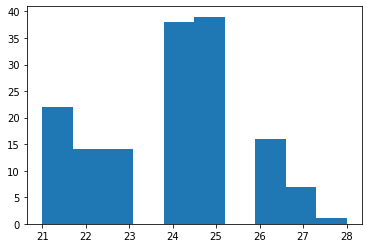

In [38]:
import matplotlib.pyplot as plt
print(len(lgths))
plt.hist(lgths)

<BarContainer object of 10 artists>

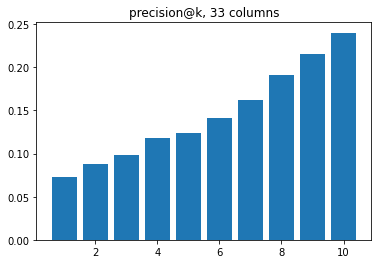

In [42]:
plt.title('precision@k, 33 columns')
plt.bar(np.arange(1, at_k+1), pk)

In [41]:
linear_model.linear.weight

Parameter containing:
tensor([[-5.3650e-04, -3.8277e-02, -3.7992e-02, -2.6162e-02,  5.6132e-02,
          2.2558e-02,  4.3561e-02,  3.4279e-03,  3.1955e-02,  7.4624e-02,
          1.2947e-02,  5.1779e-02, -2.8741e-02, -9.0148e-04,  1.2495e-02,
          5.4203e-02, -1.0910e-02,  2.0765e-02,  2.8899e-02, -1.3474e-01,
          4.9645e-02,  6.4554e-02,  1.3867e-04, -3.9073e-02, -6.0267e-06,
          1.4276e-01,  1.2215e-01, -6.4344e-02, -9.7904e-02, -4.3340e-02,
         -2.5980e-02, -1.2063e-01,  1.0804e-01]], requires_grad=True)